# Thanker Experiment Analysis Dec 2019
J. Nathan Matias

* [Pre-analysis plan](https://osf.io/e5r3q/)
* [Lab Notebook](https://docs.google.com/document/d/1M1VYaS_4CC99utvbfBr-PLm3OcYIObFNqgBTXFrg7JA/edit)
* [Datafile description](https://docs.google.com/document/d/1plhoDbQryYQ32vZMXu8YmlLSp30QTdup43k6uTePOT4/edit)
* Datafile: ~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/thanker_hardlaunch/post_experiment_analysis/all-pre_and_post_treatment_vars_with_post_survey_R_columns.csv

In [638]:
library(MASS)
library(ggplot2)
library(gmodels) #contdifains CrossTable
library(estimatr)
library(skimr)
library(corrplot)
library(ri2)
library(ri) # estlate
library(AER) # ivreg
options(repr.plot.width=4, repr.plot.height=2)

# Load datafile

In [496]:
data.dir = "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/thanker_hardlaunch/post_experiment_analysis/"
filename = "all-pre_and_post_treatment_vars_with_post_survey_R_columns.csv"
participant <- read.csv(paste(data.dir, filename, sep=""))

In [497]:
#colnames(participant)
print("complier.app.logged.in")
print(summary(participant$complier.app.logged.in))

print("complier.app")
print(summary(participant$complier.app))

print("complier.app.inclusive")
print(summary(participant$complier.app.inclusive))

[1] "complier.app.logged.in"
False  True 
  186   252 
[1] "complier.app"
False  True 
  274   164 
[1] "complier.app.inclusive"
Length  Class   Mode 
     0   NULL   NULL 


### Create complier variables and outcome variables

In [676]:
## 38 participants accessed & used the system before the experiment started
## we have assigned them randomization.block.id = -1 and omitted them from the analysis
participant <- subset(participant, randomization.block.id!=-1)

participant$complier <- participant$complier == "True"
participant$complier.int <- as.integer(participant$complier)
participant$complier.app.int <- as.integer(participant$complier.app=="True")
participant$complier.app.logged.in.int <- as.integer(participant$complier.app.logged.in=="True")
participant$complier.survey.int <- as.integer(participant$complier.survey=="True")
participant$TREAT <- participant$randomization.arm

## inclusive compliers are participants that:
### among control, logged in
### among treatment, completed the task
participant$complier.app.inclusive <- (participant$TREAT==1 & participant$complier.app!="False") | 
                                         (participant$TREAT==0 & participant$complier.app.logged.in!="False")


participant$diff.labor.hours <- participant$labor.hours.56.post.treatment - participant$labor.hours.56.pre.treatment

participant$diff.newcomer.capability <- participant$post.newcomer.capability - participant$pre.newcomer.capability
participant$diff.newcomer.intent <- participant$post.newcomer.intent - participant$pre.newcomer.intent

participant$diff.thanks.sent <- participant$wikithanks.56.post.treatment - participant$wikithanks.56.pre.treatment

participant$diff.emotionally.draining <- participant$post.emotionally.draining - participant$pre.emotionally.draining
participant$diff.monitoring.damaging.content <- participant$post.monitoring.damaging.content - participant$pre.monitoring.damaging.content
participant$diff.mentoring <- participant$post.mentoring - participant$pre.mentoring

### Checking if complier.survey is a subset of complier.app. It's not.

In [570]:
CrossTable(participant$complier.app, participant$complier.survey)


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  400 

 
                         | participant$complier.survey 
participant$complier.app |     False |      True | Row Total | 
-------------------------|-----------|-----------|-----------|
                   False |       243 |         3 |       246 | 
                         |    43.187 |    80.205 |           | 
                         |     0.988 |     0.012 |     0.615 | 
                         |     0.935 |     0.021 |           | 
                         |     0.608 |     0.007 |           | 
-------------------------|-----------|-----------|-----------|
                    True |        17 |       137 |       154 | 
                         |    68.987 |   128.119 |           | 
                         |     0.110 |     0.890 

### Checking if complier.survey is a subset of complier.app.inclusive

In [571]:
CrossTable(participant$complier.app.inclusive, participant$complier.survey)


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  400 

 
                                   | participant$complier.survey 
participant$complier.app.inclusive |     False |      True | Row Total | 
-----------------------------------|-----------|-----------|-----------|
                             FALSE |       192 |         3 |       195 | 
                                   |    33.590 |    62.382 |           | 
                                   |     0.985 |     0.015 |     0.487 | 
                                   |     0.738 |     0.021 |           | 
                                   |     0.480 |     0.007 |           | 
-----------------------------------|-----------|-----------|-----------|
                              TRUE |        68 |       137 |       205 | 
             

In [572]:
## individual participants that complied with the app
behavioral.compliers.exclusive <- subset(participant, complier.app!="False")
behavioral.compliers.inclusive <- subset(participant, complier.app.inclusive)
behavioral.compliers.login <- subset(participant, complier.app.logged.in!="False")

## individual participants that complied with the survey
survey.compliers <- subset(participant, complier)

## dataframe with a sum of how many block members complied
behavioral.block.compliance <- aggregate(participant[c('complier.app.inclusive')], by=list(participant$randomization.block.id), FUN=sum)
survey.block.compliance <- aggregate(participant[c('complier.int')], by=list(participant$randomization.block.id), FUN=sum)

## accounts in blocks where every block participant complied with the app
behavioral.block.compliers <- subset(participant, randomization.block.id %in% subset(behavioral.block.compliance, complier.app.inclusive==2)$Group.1)

## accounts in blocks where every block participant complied with the survey
survey.block.compliers <- subset(participant, randomization.block.id %in% subset(survey.block.compliance, complier.int==2)$Group.1)

# Participation and Compliance Rates

In [573]:
print(paste(nrow(participant), "total assigned"))
print("")
print(paste(nrow(behavioral.compliers.exclusive), "fully complied with the intervention"))
print(paste(nrow(behavioral.compliers.inclusive), "likely complied with the intervention"))
print(paste(nrow(behavioral.compliers.login), "at least logged in to the intervention"))
print(paste(nrow(behavioral.block.compliers), "are in blocks that likely complied with the intervention"))
print("")
print(paste(nrow(survey.compliers), "fully complied with the intervention and surveys"))
print(paste(nrow(survey.block.compliers), "are in blocks that likely complied with the intervention and also the surveys"))

[1] "400 total assigned"
[1] ""
[1] "154 fully complied with the intervention"
[1] "205 likely complied with the intervention"
[1] "238 at least logged in to the intervention"
[1] "106 are in blocks that likely complied with the intervention"
[1] ""
[1] "0 fully complied with the intervention and surveys"
[1] "0 are in blocks that likely complied with the intervention and also the surveys"


#### App Compliance Balance

In [574]:
summary(participant$lang)

ar  de  fa  pl 
  0 286  52  62

In [575]:
participant$compli

NULL

In [576]:
for(l in unique(participant$lang)){
    print("---------------------")
    print(paste("--------", l,"--------"))
    print("---------------------")
    print(paste(l,"App Compliance Balance"))

    print("Exclusive")
    CrossTable(subset(participant, lang==l)$TREAT, subset(participant, lang==l)$complier.app, 
              prop.r=FALSE, prop.c=TRUE, prop.chisq = FALSE, prop.test=FALSE, prop.t=FALSE)
    
    print("Inclusive")
    CrossTable(subset(participant, lang==l)$TREAT, subset(participant, lang==l)$complier.app.inclusive, 
              prop.r=FALSE, prop.c=TRUE, prop.chisq = FALSE, prop.test=FALSE, prop.t=FALSE)
    
    print("All Logged In Accounts")
    CrossTable(subset(participant, lang==l)$TREAT, subset(participant, lang==l)$complier.app.logged.in, 
              prop.r=FALSE, prop.c=TRUE, prop.chisq = FALSE, prop.test=FALSE, prop.t=FALSE)

}

[1] "---------------------"
[1] "-------- fa --------"
[1] "---------------------"
[1] "fa App Compliance Balance"
[1] "Exclusive"

 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  52 

 
                                     | subset(participant, lang == l)$complier.app 
subset(participant, lang == l)$TREAT |     False |      True | Row Total | 
-------------------------------------|-----------|-----------|-----------|
                                   0 |        18 |         8 |        26 | 
                                     |     0.581 |     0.381 |           | 
-------------------------------------|-----------|-----------|-----------|
                                   1 |        13 |        13 |        26 | 
                                     |     0.419 |     0.619 |           | 
-------------------------------------|-----------|-----------|-----------|
        

In [577]:
print("App Compliance Balance Overall (completion)")
CrossTable(participant$TREAT, participant$complier.app, 
           prop.r=FALSE, prop.c=TRUE, prop.chisq = FALSE, prop.test=FALSE, prop.t=FALSE)

[1] "App Compliance Balance Overall (completion)"

 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  400 

 
                  | participant$complier.app 
participant$TREAT |     False |      True | Row Total | 
------------------|-----------|-----------|-----------|
                0 |       130 |        70 |       200 | 
                  |     0.528 |     0.455 |           | 
------------------|-----------|-----------|-----------|
                1 |       116 |        84 |       200 | 
                  |     0.472 |     0.545 |           | 
------------------|-----------|-----------|-----------|
     Column Total |       246 |       154 |       400 | 
                  |     0.615 |     0.385 |           | 
------------------|-----------|-----------|-----------|

 


In [578]:
print("App Compliance Balance Overall (inclusive)")
CrossTable(participant$TREAT, participant$complier.app.inclusive, 
           prop.r=FALSE, prop.c=TRUE, prop.chisq = FALSE, prop.test=FALSE, prop.t=FALSE)

[1] "App Compliance Balance Overall (inclusive)"

 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  400 

 
                  | participant$complier.app.inclusive 
participant$TREAT |     FALSE |      TRUE | Row Total | 
------------------|-----------|-----------|-----------|
                0 |        79 |       121 |       200 | 
                  |     0.405 |     0.590 |           | 
------------------|-----------|-----------|-----------|
                1 |       116 |        84 |       200 | 
                  |     0.595 |     0.410 |           | 
------------------|-----------|-----------|-----------|
     Column Total |       195 |       205 |       400 | 
                  |     0.487 |     0.512 |           | 
------------------|-----------|-----------|-----------|

 


In [579]:
print("App Compliance Balance Overall (logged in)")
CrossTable(participant$TREAT, participant$complier.app.logged.in, 
           prop.r=FALSE, prop.c=TRUE, prop.chisq = FALSE, prop.test=FALSE, prop.t=FALSE)

[1] "App Compliance Balance Overall (logged in)"

 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  400 

 
                  | participant$complier.app.logged.in 
participant$TREAT |     False |      True | Row Total | 
------------------|-----------|-----------|-----------|
                0 |        79 |       121 |       200 | 
                  |     0.488 |     0.508 |           | 
------------------|-----------|-----------|-----------|
                1 |        83 |       117 |       200 | 
                  |     0.512 |     0.492 |           | 
------------------|-----------|-----------|-----------|
     Column Total |       162 |       238 |       400 | 
                  |     0.405 |     0.595 |           | 
------------------|-----------|-----------|-----------|

 


#### Survey compliance balance

In [580]:
print("Survey Compliance Balance")
CrossTable(participant$TREAT, participant$complier, 
           prop.r=FALSE, prop.c=TRUE, prop.chisq = FALSE, prop.test=FALSE, prop.t=FALSE)

[1] "Survey Compliance Balance"

 
   Cell Contents
|-------------------------|
|                       N |
|-------------------------|

 
Total Observations in Table:  400 

 
                  | participant$complier 
participant$TREAT |     FALSE | Row Total | 
------------------|-----------|-----------|
                0 |       200 |       200 | 
------------------|-----------|-----------|
                1 |       200 |       200 | 
------------------|-----------|-----------|
     Column Total |       400 |       400 | 
------------------|-----------|-----------|

 


### Checking Balance on Observables

In [581]:
t.test(total.edits.56.pre.treatment ~ TREAT, data = behavioral.compliers.exclusive) # no difference
t.test(total.edits.56.pre.treatment ~ TREAT, data = behavioral.compliers.inclusive) # no difference
t.test(total.edits.56.pre.treatment ~ TREAT, data = behavioral.compliers.login) # no difference
t.test(total.edits.56.pre.treatment ~ TREAT, data = behavioral.block.compliers) # no difference


	Welch Two Sample t-test

data:  total.edits.56.pre.treatment by TREAT
t = -0.29687, df = 149.72, p-value = 0.767
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -112.54081   83.14081
sample estimates:
mean in group 0 mean in group 1 
       194.5143        209.2143 



	Welch Two Sample t-test

data:  total.edits.56.pre.treatment by TREAT
t = -0.16913, df = 178.27, p-value = 0.8659
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -95.99247  80.83663
sample estimates:
mean in group 0 mean in group 1 
       201.6364        209.2143 



	Welch Two Sample t-test

data:  total.edits.56.pre.treatment by TREAT
t = -0.50318, df = 200.3, p-value = 0.6154
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -129.88802   77.07528
sample estimates:
mean in group 0 mean in group 1 
       201.6364        228.0427 



	Welch Two Sample t-test

data:  total.edits.56.pre.treatment by TREAT
t = 0.19571, df = 103.7, p-value = 0.8452
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -122.6873  149.5552
sample estimates:
mean in group 0 mean in group 1 
       252.4151        238.9811 


In [582]:
t.test(support.talk.56.pre.treatment ~ TREAT, data = behavioral.compliers.exclusive) # no difference
t.test(support.talk.56.pre.treatment ~ TREAT, data = behavioral.compliers.inclusive) # no difference
t.test(support.talk.56.pre.treatment ~ TREAT, data = behavioral.compliers.login) # no difference
t.test(support.talk.56.pre.treatment ~ TREAT, data = behavioral.block.compliers) # no difference


	Welch Two Sample t-test

data:  support.talk.56.pre.treatment by TREAT
t = -0.6531, df = 146.09, p-value = 0.5147
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -17.053403   8.581974
sample estimates:
mean in group 0 mean in group 1 
       16.72857        20.96429 



	Welch Two Sample t-test

data:  support.talk.56.pre.treatment by TREAT
t = -0.91614, df = 172.9, p-value = 0.3609
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -15.972420   5.845501
sample estimates:
mean in group 0 mean in group 1 
       15.90083        20.96429 



	Welch Two Sample t-test

data:  support.talk.56.pre.treatment by TREAT
t = -0.4658, df = 235.65, p-value = 0.6418
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -11.513868   7.110393
sample estimates:
mean in group 0 mean in group 1 
       15.90083        18.10256 



	Welch Two Sample t-test

data:  support.talk.56.pre.treatment by TREAT
t = -0.55542, df = 100.14, p-value = 0.5798
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -19.92676  11.20978
sample estimates:
mean in group 0 mean in group 1 
       17.56604        21.92453 


In [583]:
t.test(year.joined ~ TREAT, data = behavioral.compliers.exclusive) # no difference
t.test(year.joined ~ TREAT, data = behavioral.compliers.inclusive) # no difference
t.test(year.joined ~ TREAT, data = behavioral.compliers.login)     # no difference
t.test(year.joined ~ TREAT, data = behavioral.block.compliers)     # no difference


	Welch Two Sample t-test

data:  year.joined by TREAT
t = -0.5794, df = 144.85, p-value = 0.5632
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.6069519  0.8783805
sample estimates:
mean in group 0 mean in group 1 
       2010.029        2010.393 



	Welch Two Sample t-test

data:  year.joined by TREAT
t = -0.083849, df = 181.48, p-value = 0.9333
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.122326  1.030827
sample estimates:
mean in group 0 mean in group 1 
       2010.347        2010.393 



	Welch Two Sample t-test

data:  year.joined by TREAT
t = -0.36409, df = 235.9, p-value = 0.7161
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.1719735  0.8063593
sample estimates:
mean in group 0 mean in group 1 
       2010.347        2010.530 



	Welch Two Sample t-test

data:  year.joined by TREAT
t = 0.35278, df = 103.97, p-value = 0.725
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.220711  1.749013
sample estimates:
mean in group 0 mean in group 1 
       2010.226        2009.962 


#### Complier Block Balance

In [584]:
summary(factor(behavioral.block.compliers$TREAT))
summary(factor(survey.block.compliers$TREAT))

0  1 
53 53

integer(0)

# Survey Attrition

In [585]:
print(paste(nrow(subset(participant, complier.app.logged.in=="True")), "out of",
      nrow(participant), "pre-survey participants never logged in"))


[1] "238 out of 400 pre-survey participants never logged in"


In [588]:
summary(participant$complier.survey.int)

   Mode   FALSE    TRUE 
logical     260     140 

In [589]:
CrossTable(participant$complier.survey.int, participant$complier.app.inclusive)


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  400 

 
                                | participant$complier.app.inclusive 
participant$complier.survey.int |     FALSE |      TRUE | Row Total | 
--------------------------------|-----------|-----------|-----------|
                          FALSE |       192 |        68 |       260 | 
                                |    33.590 |    31.952 |           | 
                                |     0.738 |     0.262 |     0.650 | 
                                |     0.985 |     0.332 |           | 
                                |     0.480 |     0.170 |           | 
--------------------------------|-----------|-----------|-----------|
                           TRUE |         3 |       137 |       140 | 
                                |   

In [614]:
participant$has.email.int <- participant$has.email =="True"
colnames(participant)

[1] "anonymized.id"                      "lang"                              
 [3] "user.editcount"                     "user.experience.level"             
 [5] "overall.exp"                        "has.email"                         
 [7] "year.joined"                        "account.age"                       
 [9] "complier"                           "complier.survey"                   
[11] "previous.supportive.actions"        "subsequent.supportive.actions"     
[13] "diff.supportive.actions"            "previous.positive.feeling"         
[15] "subsequent.positive.feeling"        "diff.positive.feeling"             
[17] "previous.labor.hours"               "subsequent.labor.hours"            
[19] "pre.monitoring.damaging.content"    "pre.mentoring"                     
[21] "pre.newcomer.capability"            "pre.newcomer.intent"               
[23] "pre.emotionally.draining"           "pre.feel.positive"                 
[25] "post.monitoring.damaging.content"   "post.mentoring"                    
[27] "post.newcomer.capability"           "post.newcomer.intent"              
[29] "post.emotionally.draining"          "post.feel.positive"                
[31] "supportive.84.pre.treatment"        "labor.hours.84.pre.treatment"      
[33] "total.edits.84.pre.treatment"       "num.reverts.84.pre.treatment"      
[35] "project.talk.84.pre.treatment"      "support.talk.84.pre.treatment"     
[37] "wikithank.84.pre.treatment"         "wikilove.84.pre.treatment"         
[39] "block.actions.84.pre.treatment"     "randomization.block.id"            
[41] "randomization.block.size"           "randomization.arm"                 
[43] "treatment.start"                    "treatment.end"                     
[45] "complier.app"                       "complier.app.logged.in"            
[47] "complier.app.logged.in.latest.date" "num.thankees.skipped"              
[49] "num.thank.actions"                  "num.complete.activity.actions"     
[51] "treatment.elapsed.seconds"          "start.date.56.pre.treatment"       
[53] "end.date.56.pre.treatment"          "num.reverts.56.pre.treatment"      
[55] "block.actions.56.pre.treatment"     "labor.hours.56.pre.treatment"      
[57] "total.edits.56.pre.treatment"       "support.talk.56.pre.treatment"     
[59] "project.talk.56.pre.treatment"      "wikithanks.56.pre.treatment"       
[61] "wikiloves.56.pre.treatment"         "start.date.56.post.treatment"      
[63] "end.date.56.post.treatment"         "num.reverts.56.post.treatment"     
[65] "block.actions.56.post.treatment"    "labor.hours.56.post.treatment"     
[67] "total.edits.56.post.treatment"      "support.talk.56.post.treatment"    
[69] "project.talk.56.post.treatment"     "wikithanks.56.post.treatment"      
[71] "wikiloves.56.post.treatment"        "complier.int"                      
[73] "complier.app.int"                   "complier.app.logged.in.int"        
[75] "TREAT"                              "complier.app.inclusive"            
[77] "diff.labor.hours"                   "diff.newcomer.capability"          
[79] "diff.newcomer.intent"               "diff.thanks.sent"                  
[81] "diff.emotionally.draining"          "diff.monitoring.damaging.content"  
[83] "diff.mentoring"                     "complier.survey.int"               
[85] "has.email.int"

In [ ]:
participant$pre.newcomer.capability

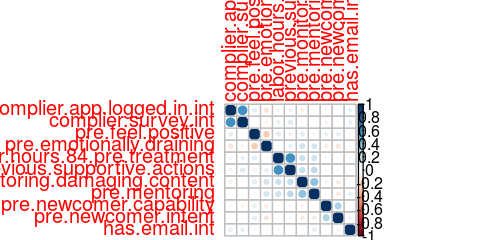

In [620]:
corrplot(cor(participant[c("complier.app.logged.in.int",
                           "complier.survey.int",
                           "pre.feel.positive",
                           "pre.emotionally.draining",
                           "labor.hours.84.pre.treatment",
                           "previous.supportive.actions",
                           "pre.monitoring.damaging.content",
                           "pre.mentoring",
                           "pre.newcomer.capability",
                           "pre.newcomer.intent", 
                           "has.email.int")]))

In [626]:
CrossTable(participant$complier.app.logged.in.int, participant$has.email.int)


 
   Cell Contents
|-------------------------|
|                       N |
| Chi-square contribution |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  400 

 
                                       | participant$has.email.int 
participant$complier.app.logged.in.int |     FALSE |      TRUE | Row Total | 
---------------------------------------|-----------|-----------|-----------|
                                     1 |        13 |       149 |       162 | 
                                       |     2.376 |     0.132 |           | 
                                       |     0.080 |     0.920 |     0.405 | 
                                       |     0.619 |     0.393 |           | 
                                       |     0.033 |     0.372 |           | 
---------------------------------------|-----------|-----------|-----------|
                                     2 |         8 | 

In [637]:
cor.test(participant$complier.app.logged.in.int, participant$pre.feel.positive)
summary(lm(complier.app.logged.in.int ~ pre.feel.positive, data=participant))


	Pearson's product-moment correlation

data:  participant$complier.app.logged.in.int and participant$pre.feel.positive
t = 2.3198, df = 398, p-value = 0.02086
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.01765054 0.21116262
sample estimates:
      cor 
0.1155024 



Call:
lm(formula = complier.app.logged.in.int ~ pre.feel.positive, 
    data = participant)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6487 -0.5830  0.3513  0.4170  0.6142 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.32010    0.12100   10.91   <2e-16 ***
pre.feel.positive  0.06573    0.02833    2.32   0.0209 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4888 on 398 degrees of freedom
Multiple R-squared:  0.01334,	Adjusted R-squared:  0.01086 
F-statistic: 5.381 on 1 and 398 DF,  p-value: 0.02086


In [636]:
cor.test(participant$complier.app.logged.in.int, participant$pre.emotionally.draining)


	Pearson's product-moment correlation

data:  participant$complier.app.logged.in.int and participant$pre.emotionally.draining
t = -2.8296, df = 398, p-value = 0.004896
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.23524280 -0.04297019
sample estimates:
       cor 
-0.1404302 


# Univariate Summary Statistics & Data Validation Method for a Sub-samble

In [223]:
colnames(behavioral.compliers.exclusive)

[1] "anonymized.id"                      "lang"                              
 [3] "user.editcount"                     "user.experience.level"             
 [5] "overall.exp"                        "has.email"                         
 [7] "year.joined"                        "account.age"                       
 [9] "complier"                           "complier.survey"                   
[11] "previous.supportive.actions"        "subsequent.supportive.actions"     
[13] "diff.supportive.actions"            "previous.positive.feeling"         
[15] "subsequent.positive.feeling"        "diff.positive.feeling"             
[17] "previous.labor.hours"               "subsequent.labor.hours"            
[19] "pre.monitoring.damaging.content"    "pre.mentoring"                     
[21] "pre.newcomer.capability"            "pre.newcomer.intent"               
[23] "pre.emotionally.draining"           "pre.feel.positive"                 
[25] "post.monitoring.damaging.content"   "post.mentoring"                    
[27] "post.newcomer.capability"           "post.newcomer.intent"              
[29] "post.emotionally.draining"          "post.feel.positive"                
[31] "supportive.84.pre.treatment"        "labor.hours.84.pre.treatment"      
[33] "total.edits.84.pre.treatment"       "num.reverts.84.pre.treatment"      
[35] "project.talk.84.pre.treatment"      "support.talk.84.pre.treatment"     
[37] "wikithank.84.pre.treatment"         "wikilove.84.pre.treatment"         
[39] "block.actions.84.pre.treatment"     "randomization.block.id"            
[41] "randomization.block.size"           "randomization.arm"                 
[43] "treatment.start"                    "treatment.end"                     
[45] "complier.app"                       "complier.app.logged.in"            
[47] "complier.app.logged.in.latest.date" "num.thankees.skipped"              
[49] "num.thank.actions"                  "num.complete.activity.actions"     
[51] "treatment.elapsed.seconds"          "start.date.56.pre.treatment"       
[53] "end.date.56.pre.treatment"          "num.reverts.56.pre.treatment"      
[55] "block.actions.56.pre.treatment"     "labor.hours.56.pre.treatment"      
[57] "total.edits.56.pre.treatment"       "support.talk.56.pre.treatment"     
[59] "project.talk.56.pre.treatment"      "wikithanks.56.pre.treatment"       
[61] "wikiloves.56.pre.treatment"         "start.date.56.post.treatment"      
[63] "end.date.56.post.treatment"         "num.reverts.56.post.treatment"     
[65] "block.actions.56.post.treatment"    "labor.hours.56.post.treatment"     
[67] "total.edits.56.post.treatment"      "support.talk.56.post.treatment"    
[69] "project.talk.56.post.treatment"     "wikithanks.56.post.treatment"      
[71] "wikiloves.56.post.treatment"        "complier.int"                      
[73] "complier.app.int"                   "complier.app.logged.in.int"        
[75] "TREAT"                              "complier.app.inclusive"            
[77] "diff.labor.hours"                   "diff.newcomer.capability"          
[79] "diff.newcomer.intent"               "diff.thanks.sent"                  
[81] "diff.emotionally.draining"          "diff.monitoring.damaging.content"  
[83] "diff.mentoring"

In [231]:
summary.stats <- function(df, title){
    print("=====================")
    print(title)
    print("=====================")
    print("")
    
    print(paste(nrow(df), "participants in subsample"))
    print(paste(nrow(subset(df, complier)), "Survey Compliers in Subsample"))
    print("")

    print("language")
    print(summary(df$lang))
    print("")
    

    print(skim(df[c("TREAT", "diff.supportive.actions", "diff.labor.hours", 
                    "diff.newcomer.capability", "diff.newcomer.intent", 
                    "diff.thanks.sent", "diff.positive.feeling", 
                    "diff.emotionally.draining",
                    "diff.mentoring", "diff.thanks.sent")]))
}

In [232]:
# summary.stats <- function(df, title){
#     print("=====================")
#     print(title)
#     print("=====================")
#     print("")
    
#     print(paste(nrow(df), "participants in subsample"))
#     print(paste(nrow(subset(df, complier)), "Survey Compliers in Subsample"))
#     print("")

#     print("language")
#     print(summary(df$lang))
#     print("")
    
#     print("==== Supportive Actions ====")
#     print("56 days before")
#     print(summary(df$support.talk.56.pre.treatment))
#     print("56 days after")
#     print(summary(df$support.talk.56.post.treatment))
#     print("Difference in supportive actions 56 days before and after")
#     print(summary(df$diff.supportive.actions))
#     print("")

#     print("==== Labor Hours ====")
#     print("Labor Hours Before")
#     print(summary(df$labor.hours.56.pre.treatment))
#     print("Labor Hours After")
#     print(summary(df$labor.hours.56.post.treatment))
#     print("Difference in labor hours before and after")
#     print(summary(df$diff.labor.hours))
#     print("")

#     print("==== Thanks Sent ====")
#     print("Difference in thanks sent before and after")
#     print(summary(df$diff.thanks.sent))
#     print("")
#     print("Difference in positive feeling before and after")
#     print(summary(df$diff.positive.feeling))
#     print("")   
#     print("Difference in view of newcomer intent before and after")
#     print(summary(df$diff.newcomer.intent))
#     print("")   
#     print("Difference in view of newcomer capability before and after")
#     print(summary(df$diff.newcomer.capability))
#     print("")  
    
#     print(ggplot(df, aes(diff.supportive.actions)) + 
#           geom_histogram(bins=40) + 
#           geom_vline(xintercept=mean(df$diff.supportive.actions), color="red") +
#           ggtitle("Difference in supportive actions 56 days before & after") +
#           facet_grid(TREAT ~ . ) +
#           theme_bw() + 
#           theme(plot.title = element_text(size=8),
#                 axis.title.x = element_text(size=6.5),
#                 axis.title.y = element_text(size=6.5)))
    
#     print(ggplot(df, aes(diff.labor.hours)) + 
#           geom_histogram(bins=5) + 
#           theme_bw() + 
#           geom_vline(xintercept=mean(df$diff.labor.hours), color="red") +
#           ggtitle("Difference in labor hours 56 days before & after") +
#           facet_grid(TREAT ~ . ) +
#           theme_bw() + 
#           theme(plot.title = element_text(size=8),
#                 axis.title.x = element_text(size=6.5),
#                 axis.title.y = element_text(size=6.5))) 
    
#     print(ggplot(df, aes(diff.thanks.sent)) + 
#           geom_histogram(bins=5) + 
#           theme_bw() + 
#           geom_vline(xintercept=mean(df$diff.thanks.sent), color="red") +
#           ggtitle("Difference in thanks sent 56 days before & after") +
#           facet_grid(TREAT ~ . ) +
#           theme_bw() + 
#           theme(plot.title = element_text(size=8),
#                 axis.title.x = element_text(size=6.5),
#                 axis.title.y = element_text(size=6.5)))          
    
#     print(ggplot(df, aes(diff.positive.feeling)) + 
#           geom_histogram(bins=5) + 
#           theme_bw() + 
#           geom_vline(xintercept=mean(df$diff.positive.feeling,  na.rm=TRUE), color="red") +
#           ggtitle("Difference in positive feeling about Wikipedia\n contributions 56 days before & after") +
#           facet_grid(TREAT ~ . ) +
#           theme_bw() + 
#           theme(plot.title = element_text(size=8),
#                 axis.title.x = element_text(size=6.5),
#                 axis.title.y = element_text(size=6.5)))
    
#     print(ggplot(df, aes(diff.newcomer.intent)) + 
#           geom_histogram(bins=5) + 
#           theme_bw() + 
#           geom_vline(xintercept=mean(df$diff.newcomer.intent,  na.rm=TRUE), color="red") +
#           ggtitle("Difference in view of newcomer intent 56 days before & after") +
#           facet_grid(TREAT ~ . ) +
#           theme_bw() + 
#           theme(plot.title = element_text(size=8),
#                 axis.title.x = element_text(size=6.5),
#                 axis.title.y = element_text(size=6.5)))
    
#     print(ggplot(df, aes(diff.newcomer.capability)) + 
#           geom_histogram(bins=5) + 
#           theme_bw() + 
#           geom_vline(xintercept=mean(df$diff.newcomer.capability,  na.rm=TRUE), color="red") +
#           ggtitle("Difference in view of newcomer capability 56 days before & after") +
#           facet_grid(TREAT ~ . ) +
#           theme_bw() + 
#           theme(plot.title = element_text(size=8),
#                 axis.title.x = element_text(size=6.5),
#                 axis.title.y = element_text(size=6.5)))

    
# }

In [233]:
#participant$diff.positive.feeling
#summary(behavioral.compliers.login$labor.hours.56.post.treatment)

# Summary Statistics & Data Validation

In [234]:
summary.stats(behavioral.compliers.login, "Behavioral Compliers (login)")

[1] "====================="
[1] "Behavioral Compliers (login)"
[1] "====================="
[1] ""
[1] "238 participants in subsample"
[1] "137 Survey Compliers in Subsample"
[1] ""
[1] "language"
 ar  de  fa  pl 
  0 183  28  27 
[1] ""
Skim summary statistics
 n obs: 238 
 n variables: 10 

── Variable type:integer ───────────────────────────────────────────────────────
                variable missing complete   n  mean    sd   p0   p25 p50 p75
 diff.supportive.actions       0      238 238  1.94 49.35 -250 -6.75   0   3
        diff.thanks.sent       0      238 238 -0.23  8.21  -59 -1      0   1
      diff.thanks.sent.1       0      238 238 -0.23  8.21  -59 -1      0   1
                   TREAT       0      238 238  0.49  0.5     0  0      0   1
 p100     hist
  388 ▁▁▂▇▁▁▁▁
   54 ▁▁▁▁▇▁▁▁
   54 ▁▁▁▁▇▁▁▁
    1 ▇▁▁▁▁▁▁▇

── Variable type:numeric ───────────────────────────────────────────────────────
                  variable missing complete   n     mean    sd      p0   p25
 diff.e

In [235]:
summary.stats(behavioral.compliers.inclusive, "Behavioral Compliers (Inclusive)")

[1] "====================="
[1] "Behavioral Compliers (Inclusive)"
[1] "====================="
[1] ""
[1] "205 participants in subsample"
[1] "137 Survey Compliers in Subsample"
[1] ""
[1] "language"
 ar  de  fa  pl 
  0 152  26  27 
[1] ""
Skim summary statistics
 n obs: 205 
 n variables: 10 

── Variable type:integer ───────────────────────────────────────────────────────
                variable missing complete   n  mean    sd   p0 p25 p50 p75 p100
 diff.supportive.actions       0      205 205  1.21 51.87 -250  -7   0   3  388
        diff.thanks.sent       0      205 205 -0.17  8.67  -59  -1   0   1   54
      diff.thanks.sent.1       0      205 205 -0.17  8.67  -59  -1   0   1   54
                   TREAT       0      205 205  0.41  0.49    0   0   0   1    1
     hist
 ▁▁▂▇▁▁▁▁
 ▁▁▁▁▇▁▁▁
 ▁▁▁▁▇▁▁▁
 ▇▁▁▁▁▁▁▆

── Variable type:numeric ───────────────────────────────────────────────────────
                  variable missing complete   n   mean    sd      p0   p25
 diff.emotional

In [236]:
summary.stats(behavioral.compliers.exclusive, "Behavioral Compliers (Inclusive)")

[1] "====================="
[1] "Behavioral Compliers (Inclusive)"
[1] "====================="
[1] ""
[1] "154 participants in subsample"
[1] "137 Survey Compliers in Subsample"
[1] ""
[1] "language"
 ar  de  fa  pl 
  0 114  21  19 
[1] ""
Skim summary statistics
 n obs: 154 
 n variables: 10 

── Variable type:integer ───────────────────────────────────────────────────────
                variable missing complete   n   mean    sd   p0   p25 p50 p75
 diff.supportive.actions       0      154 154  3.44  58.99 -250 -5.75   0   4
        diff.thanks.sent       0      154 154 -0.078  9.78  -59 -1      0   1
      diff.thanks.sent.1       0      154 154 -0.078  9.78  -59 -1      0   1
                   TREAT       0      154 154  0.55   0.5     0  0      1   1
 p100     hist
  388 ▁▁▂▇▁▁▁▁
   54 ▁▁▁▁▇▁▁▁
   54 ▁▁▁▁▇▁▁▁
    1 ▇▁▁▁▁▁▁▇

── Variable type:numeric ───────────────────────────────────────────────────────
                  variable missing complete   n   mean    sd      p0   p25


### Randomization Block
Question: Why do some participants have a randomization block of -1? (I expect it's in the lab notebook)

In [248]:
participant$counter <- 1
df <- subset(participant[c("randomization.block.id", "counter")],
                 randomization.block.id!=-1)
ag.df <- aggregate(df, 
                   by=list(df$randomization.block.id), FUN=sum)
summary(ag.df$counter)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      2       2       2       2       2       2 

### Survey Compliance

In [249]:
summary(participant$complier)

   Mode   FALSE    TRUE 
logical     263     137 

### App Compliance

In [250]:
summary(participant$complier.app)

False  True 
  246   154

### Year Joined

In [251]:
summary(factor(participant$year.joined))

2002 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 
   2    1   73   39   47   32   32   27   23   20   23   20   21   18   18    4

### Assignment

In [252]:
summary(factor(subset(participant, randomization.block.id!=-1)$randomization.arm))

0   1 
200 200

# Estimating the Treatment Effects
## Supportive Actions

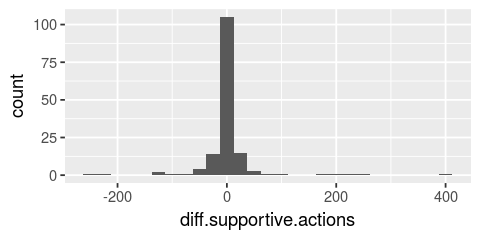

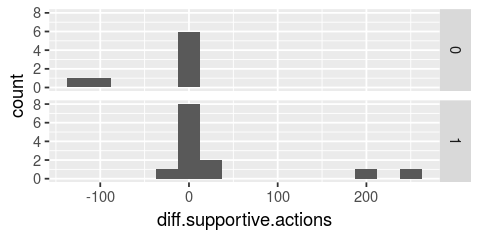

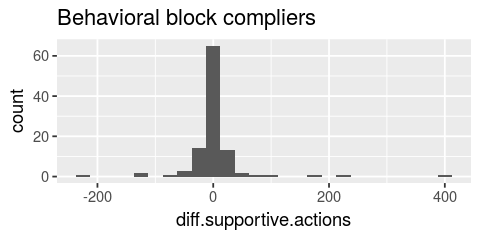

In [307]:
ggplot(behavioral.compliers.exclusive, aes(diff.supportive.actions)) +
    geom_histogram(binwidth=25)
ggplot(subset(behavioral.compliers.exclusive, lang=="fa"), aes(diff.supportive.actions)) +
    geom_histogram(binwidth=25) +
    facet_grid(TREAT ~ . )

ggplot(behavioral.block.compliers, aes(diff.supportive.actions)) +
    geom_histogram(binwidth=25) +
    ggtitle("Behavioral block compliers")


In [274]:
difference_in_means(diff.supportive.actions ~ TREAT, blocks= 
                    randomization.block.id ,
                    data = behavioral.block.compliers)

Design:  Matched-pair 
      Estimate Std. Error   t value  Pr(>|t|)  CI Lower CI Upper DF
TREAT 4.792453   9.425568 0.5084524 0.6132865 -14.12133 23.70624 52

In [309]:
difference_in_means(diff.supportive.actions ~ TREAT, 
                    data = behavioral.compliers.inclusive)

Design:  Standard 
      Estimate Std. Error   t value  Pr(>|t|)  CI Lower CI Upper       DF
TREAT 6.603011   8.349716 0.7908066 0.4308427 -9.953283  23.1593 104.8109

In [313]:
## ACROSS EVERYONE
difference_in_means(diff.supportive.actions ~ TREAT, 
                    data = behavioral.compliers.exclusive)

print("FA")
## WITHIN PERSIAN
difference_in_means(diff.supportive.actions ~ TREAT, 
                    data = subset(behavioral.compliers.exclusive, lang=="fa"))

print("PL")
## WITHIN POLISH
difference_in_means(diff.supportive.actions ~ TREAT, 
                    data = subset(behavioral.compliers.exclusive, lang=="pl"))

## WITHIN GERMAN
print("DE")
difference_in_means(diff.supportive.actions ~ TREAT, 
                    data = subset(behavioral.compliers.exclusive, lang=="de"))

Design:  Standard 
      Estimate Std. Error   t value  Pr(>|t|)  CI Lower CI Upper       DF
TREAT 3.678571   9.098414 0.4043091 0.6866445 -14.32019 21.67734 131.0539

[1] "FA"


Design:  Standard 
      Estimate Std. Error  t value   Pr(>|t|) CI Lower CI Upper       DF
TREAT 62.86538   28.74686 2.186861 0.04146574 2.696938 123.0338 18.99726

[1] "PL"


Design:  Standard 
       Estimate Std. Error     t value  Pr(>|t|) CI Lower CI Upper     DF
TREAT -1.557143   22.18817 -0.07017897 0.9448702 -48.3703 45.25601 16.999

[1] "DE"


Design:  Standard 
       Estimate Std. Error    t value Pr(>|t|)  CI Lower CI Upper       DF
TREAT -3.210526   10.22293 -0.3140514 0.754253 -23.53701 17.11596 84.83964

In [277]:
difference_in_means(diff.supportive.actions ~ TREAT, 
                    data = behavioral.compliers.login)

Design:  Standard 
      Estimate Std. Error  t value  Pr(>|t|) CI Lower CI Upper       DF
TREAT 6.983047   6.461541 1.080709 0.2813695 -5.77288 19.73897 168.6401

In [314]:
difference_in_means(diff.supportive.actions ~ TREAT, blocks=randomization.block.id, 
                    data = participant)

Design:  Matched-pair 
      Estimate Std. Error    t value  Pr(>|t|)  CI Lower CI Upper  DF
TREAT    -1.28   3.805815 -0.3363274 0.7369784 -8.784902 6.224902 199

### Randomization Inference

In [646]:
declaration <- 
  with(participant,{
    declare_ra(
      blocks = participant$randomization.block.id)
  })

participant$Z <- participant$TREAT
participant$Y1 <- participant$diff.supportive.actions
participant$Y2 <- participant$diff.positive.feeling


ri2_out_Y1 <- conduct_ri(
  Y1 ~ Z,
  sharp_hypothesis = 0,
  declaration = declaration,
  data = participant
)

participant.imp <- participant

participant.imp[participant.imp$TREAT==0 & 
                participant.imp$complier.survey=="False",]$post.feel.positive <- 
                    mean(subset(participant, TREAT==0)$post.feel.positive, na.rm=TRUE)

participant.imp[participant.imp$TREAT==1 & 
                participant.imp$complier.survey=="False",]$post.feel.positive <- 
                    mean(subset(participant, TREAT==1)$post.feel.positive, na.rm=TRUE)
participant.imp$diff.positive.feeling <- participant.imp$post.feel.positive - participant.imp$pre.feel.positive


ri2_out_Y2 <- conduct_ri(
  Y ~ Z,
  sharp_hypothesis = 0,
  declaration = declaration,
  data = participant.imp
)

term,estimate,two_tailed_p_value
Z,-1.28,0.726


### Two Stage Least Squares Regression

In [534]:
#colnames(participant)

In [535]:
#participant$complier.app.inclusive

In [536]:
# cor(participant[c("complier.app.int", "complier.app.inclusive", "complier.app.logged.in.int", 
#                   "year.joined", 
#                   "previous.labor.hours", "previous.supportive.actions",
#                   "total.edits.56.pre.treatment",
#                   "pre.feel.positive", "pre.emotionally.draining"
#                  )], method = "pearson")

In [537]:
# cor(participant[c("complier.app.int", "complier.app.inclusive", "complier.app.logged.in.int", 
#                   "year.joined", 
#                   "previous.labor.hours", "previous.supportive.actions",
#                   "total.edits.56.pre.treatment",
#                   "pre.feel.positive", "pre.emotionally.draining"
#                  )], method = "pearson")

In [538]:
# ## Two Stage Least Squares Regression
# y <- participant$diff.supportive.actions 
# Z <- as.integer(participant$complier.app)-1
# D <- as.integer(participant$TREAT)-1
# probs = genprobexact(as.integer(participant$TREAT)-1, #assignment
#                      participant$randomization.block.id)

# late <- estlate(y,D,Z,prob=probs)
# late

In [ ]:
participant$complier.app.logged.in

In [539]:
summary(ivreg(diff.positive.feeling ~ TREAT | previous.supportive.actions + TREAT , 
              data=participant))

### Positive Feeling

In [540]:
#survey.block.compliers$previous.positive.feeling

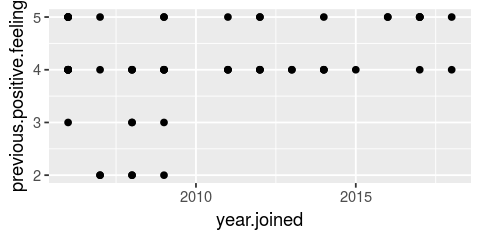

In [541]:
ggplot(survey.block.compliers, aes(year.joined, previous.positive.feeling)) +
    geom_point()

In [545]:
nrow(survey.block.compliers)
difference_in_means(diff.positive.feeling ~ TREAT, 
                    blocks = randomization.block.id,
                    data=survey.block.compliers)

[1] 58

Design:  Matched-pair 
        Estimate Std. Error   t value   Pr(>|t|)   CI Lower   CI Upper DF
TREAT -0.2758621  0.1561273 -1.766904 0.08814441 -0.5956744 0.04395027 28

In [546]:
difference_in_means(diff.positive.feeling ~ TREAT,
                    data=survey.compliers)

summary(lm(diff.positive.feeling ~ TREAT + year.joined, data=survey.compliers))

Design:  Standard 
        Estimate Std. Error   t value   Pr(>|t|)   CI Lower    CI Upper
TREAT -0.2533248   0.117356 -2.158602 0.03273018 -0.4855139 -0.02113563
            DF
TREAT 129.1475


Call:
lm(formula = diff.positive.feeling ~ TREAT + year.joined, data = survey.compliers)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.15196 -0.16499  0.08003  0.10934  2.08980 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) -6.388392  29.890152  -0.214   0.8311  
TREAT       -0.254783   0.117477  -2.169   0.0319 *
year.joined  0.003257   0.014870   0.219   0.8270  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6842 on 134 degrees of freedom
Multiple R-squared:  0.03398,	Adjusted R-squared:  0.01956 
F-statistic: 2.356 on 2 and 134 DF,  p-value: 0.09867


# Exploratory Data Analysis

### Effect on Labor Hours

In [547]:
difference_in_means(diff.labor.hours ~ TREAT, blocks=randomization.block.id,
                    data=subset(participant, randomization.block.id!=-1))

Design:  Matched-pair 
       Estimate Std. Error   t value  Pr(>|t|)  CI Lower CI Upper  DF
TREAT -2.224575   1.943111 -1.144852 0.2536454 -6.056305 1.607155 199

In [548]:
difference_in_means(diff.labor.hours ~ TREAT, data=behavioral.compliers.login)

Design:  Standard 
      Estimate Std. Error   t value  Pr(>|t|)  CI Lower CI Upper       DF
TREAT 1.223975   2.776042 0.4409067 0.6596901 -4.245423 6.693374 232.6123

### Effect on Thanks Sent

In [509]:
difference_in_means(diff.thanks.sent ~ TREAT, data=behavioral.compliers.inclusive)

Design:  Standard 
      Estimate Std. Error  t value  Pr(>|t|)  CI Lower CI Upper       DF
TREAT 1.349961   1.294967 1.042467 0.2989311 -1.209502 3.909424 144.9098

### Effect on Sense of Newcomer Capability

In [551]:
difference_in_means(diff.newcomer.capability ~ TREAT, data=survey.compliers)

Design:  Standard 
         Estimate Std. Error   t value  Pr(>|t|)   CI Lower  CI Upper       DF
TREAT -0.07057057  0.1580446 -0.446523 0.6560266 -0.3834973 0.2423562 119.6496

### Effect on Sense of Newcomer Intent

In [552]:
difference_in_means(diff.newcomer.intent ~ TREAT, data=survey.compliers)

Design:  Standard 
        Estimate Std. Error   t value  Pr(>|t|)   CI Lower   CI Upper       DF
TREAT -0.2039897  0.1530568 -1.332771 0.1851385 -0.5070396 0.09906017 119.6886

#### Effect on Emotionally Draining

In [553]:
difference_in_means(diff.emotionally.draining ~ TREAT, data=survey.compliers)

Design:  Standard 
         Estimate Std. Error    t value  Pr(>|t|)   CI Lower  CI Upper       DF
TREAT -0.02466752  0.1377447 -0.1790814 0.8581425 -0.2970862 0.2477512 134.8906

#### Effect on Mentoring

In [555]:
difference_in_means(diff.mentoring ~ TREAT, data=survey.compliers)

Design:  Standard 
        Estimate Std. Error   t value  Pr(>|t|)   CI Lower  CI Upper       DF
TREAT 0.03646504  0.1026822 0.3551252 0.7230851 -0.1667253 0.2396553 126.9506

#### Effect on Monitoring Damaging Content

In [556]:
difference_in_means(diff.monitoring.damaging.content ~ TREAT, data=survey.compliers)

Design:  Standard 
          Estimate Std. Error     t value  Pr(>|t|)   CI Lower CI Upper
TREAT -0.006435006   0.143683 -0.04478614 0.9643441 -0.2906011 0.277731
            DF
TREAT 134.7227

In [564]:
difference_in_means(diff.thanks.sent ~ TREAT, data=behavioral.compliers.login)

Design:  Standard 
      Estimate Std. Error t value  Pr(>|t|)  CI Lower CI Upper       DF
TREAT  1.00106   1.068161 0.93718 0.3496602 -1.103699 3.105819 227.4131

In [554]:
colnames(survey.compliers)

[1] "anonymized.id"                      "lang"                              
 [3] "user.editcount"                     "user.experience.level"             
 [5] "overall.exp"                        "has.email"                         
 [7] "year.joined"                        "account.age"                       
 [9] "complier"                           "complier.survey"                   
[11] "previous.supportive.actions"        "subsequent.supportive.actions"     
[13] "diff.supportive.actions"            "previous.positive.feeling"         
[15] "subsequent.positive.feeling"        "diff.positive.feeling"             
[17] "previous.labor.hours"               "subsequent.labor.hours"            
[19] "pre.monitoring.damaging.content"    "pre.mentoring"                     
[21] "pre.newcomer.capability"            "pre.newcomer.intent"               
[23] "pre.emotionally.draining"           "pre.feel.positive"                 
[25] "post.monitoring.damaging.content"   "post.mentoring"                    
[27] "post.newcomer.capability"           "post.newcomer.intent"              
[29] "post.emotionally.draining"          "post.feel.positive"                
[31] "supportive.84.pre.treatment"        "labor.hours.84.pre.treatment"      
[33] "total.edits.84.pre.treatment"       "num.reverts.84.pre.treatment"      
[35] "project.talk.84.pre.treatment"      "support.talk.84.pre.treatment"     
[37] "wikithank.84.pre.treatment"         "wikilove.84.pre.treatment"         
[39] "block.actions.84.pre.treatment"     "randomization.block.id"            
[41] "randomization.block.size"           "randomization.arm"                 
[43] "treatment.start"                    "treatment.end"                     
[45] "complier.app"                       "complier.app.logged.in"            
[47] "complier.app.logged.in.latest.date" "num.thankees.skipped"              
[49] "num.thank.actions"                  "num.complete.activity.actions"     
[51] "treatment.elapsed.seconds"          "start.date.56.pre.treatment"       
[53] "end.date.56.pre.treatment"          "num.reverts.56.pre.treatment"      
[55] "block.actions.56.pre.treatment"     "labor.hours.56.pre.treatment"      
[57] "total.edits.56.pre.treatment"       "support.talk.56.pre.treatment"     
[59] "project.talk.56.pre.treatment"      "wikithanks.56.pre.treatment"       
[61] "wikiloves.56.pre.treatment"         "start.date.56.post.treatment"      
[63] "end.date.56.post.treatment"         "num.reverts.56.post.treatment"     
[65] "block.actions.56.post.treatment"    "labor.hours.56.post.treatment"     
[67] "total.edits.56.post.treatment"      "support.talk.56.post.treatment"    
[69] "project.talk.56.post.treatment"     "wikithanks.56.post.treatment"      
[71] "wikiloves.56.post.treatment"        "complier.int"                      
[73] "complier.app.int"                   "complier.app.logged.in.int"        
[75] "TREAT"                              "complier.app.inclusive"            
[77] "diff.labor.hours"                   "diff.newcomer.capability"          
[79] "diff.newcomer.intent"               "diff.thanks.sent"                  
[81] "diff.emotionally.draining"          "diff.monitoring.damaging.content"  
[83] "diff.mentoring"

### Effect Variation Based on Previous Supportive Actions

In [129]:
summary(lm(diff.supportive.actions ~ TREAT + previous.supportive.actions,
                    data = subset(participant, randomization.block.id!=-1 & lang=="de")))


Call:
lm(formula = diff.supportive.actions ~ TREAT + previous.supportive.actions, 
    data = subset(participant, randomization.block.id != -1 & 
        lang == "de"))

Residuals:
     Min       1Q   Median       3Q      Max 
-277.323   -6.455    2.580    4.606  275.201 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -2.58046    3.55875  -0.725    0.469    
TREAT                       -2.02526    4.74929  -0.426    0.670    
previous.supportive.actions  0.23481    0.03876   6.058 4.38e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 40.14 on 283 degrees of freedom
Multiple R-squared:  0.1158,	Adjusted R-squared:  0.1096 
F-statistic: 18.54 on 2 and 283 DF,  p-value: 2.723e-08


### Effect Variation Based on Number of Skips

In [149]:
#participant$treatment.elapsed.seconds
summary(lm(diff.supportive.actions ~ num.thankees.skipped, data = subset(participant, (complier.app!="False" & TREAT))))

summary(lm(diff.labor.hours ~ num.thankees.skipped, data = subset(participant, (complier.app!="False" & TREAT))))

summary(lm(diff.positive.feeling ~ num.thankees.skipped, data = subset(participant, (complier.app!="False" & TREAT))))


Call:
lm(formula = diff.supportive.actions ~ num.thankees.skipped, 
    data = subset(participant, (complier.app != "False" & TREAT)))

Residuals:
    Min      1Q  Median      3Q     Max 
-258.37  -12.46   -5.09   -1.21  382.57 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)
(Intercept)            3.4723     9.2201   0.377    0.707
num.thankees.skipped   0.3262     0.9500   0.343    0.732

Residual standard error: 72.37 on 82 degrees of freedom
Multiple R-squared:  0.001436,	Adjusted R-squared:  -0.01074 
F-statistic: 0.1179 on 1 and 82 DF,  p-value: 0.7322



Call:
lm(formula = diff.labor.hours ~ num.thankees.skipped, data = subset(participant, 
    (complier.app != "False" & TREAT)))

Residuals:
     Min       1Q   Median       3Q      Max 
-103.745   -7.421   -0.316    1.909   96.582 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)
(Intercept)           -0.7616     2.9933  -0.254    0.800
num.thankees.skipped   0.1501     0.3084   0.487    0.628

Residual standard error: 23.49 on 82 degrees of freedom
Multiple R-squared:  0.002881,	Adjusted R-squared:  -0.009279 
F-statistic: 0.2369 on 1 and 82 DF,  p-value: 0.6277



Call:
lm(formula = diff.positive.feeling ~ num.thankees.skipped, data = subset(participant, 
    (complier.app != "False" & TREAT)))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.89389  0.05984  0.09794  0.10815  2.10066 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)
(Intercept)          -0.108827   0.090557  -1.202    0.233
num.thankees.skipped  0.002722   0.008844   0.308    0.759

Residual standard error: 0.6697 on 72 degrees of freedom
  (10 observations deleted due to missingness)
Multiple R-squared:  0.001314,	Adjusted R-squared:  -0.01256 
F-statistic: 0.0947 on 1 and 72 DF,  p-value: 0.7592


### Survey outcome varied by language

In [ ]:
summary(factor(survey.compliers$previous.positive.feeling))

# Imputing Values for Missing Observations

In [484]:
participant.imp <- participant

In [485]:
#participant$complier.survey=="False"

In [486]:
mean(subset(participant, TREAT==0)$post.feel.positive, na.rm=TRUE)
mean(subset(participant, TREAT==1)$post.feel.positive, na.rm=TRUE)

[1] 4.301587

[1] 4.142857

#### IMPUTE POST FEEL POSITIVE

In [700]:
participant.imp[participant.imp$TREAT==0 & 
                participant.imp$complier.survey=="False",]$post.feel.positive <- 
                    mean(subset(participant, TREAT==0)$post.feel.positive, na.rm=TRUE)

participant.imp[participant.imp$TREAT==1 & 
                participant.imp$complier.survey=="False",]$post.feel.positive <- 
                    mean(subset(participant, TREAT==1)$post.feel.positive, na.rm=TRUE)
participant.imp$diff.positive.feeling <- participant.imp$post.feel.positive - participant.imp$pre.feel.positive

#### IMPUTE POST EMOTIONALLY DRAINING

In [489]:
participant.imp[participant.imp$TREAT==0 & 
                participant.imp$complier.survey=="False",]$post.emotionally.draining <- 
                    mean(subset(participant, TREAT==0)$post.emotionally.draining, na.rm=TRUE)

participant.imp[participant.imp$TREAT==1 & 
                participant.imp$complier.survey=="False",]$post.emotionally.draining <- 
                    mean(subset(participant, TREAT==1)$post.emotionally.draining, na.rm=TRUE)
participant.imp$diff.emotionally.draining <- participant.imp$post.emotionally.draining - participant.imp$pre.emotionally.draining

In [490]:
mean(subset(participant, TREAT==1)$post.emotionally.draining, na.rm=TRUE)

[1] 2.116883

In [699]:
difference_in_means(diff.positive.feeling ~ TREAT, 
                    data = participant.imp)

Design:  Standard 
        Estimate Std. Error   t value   Pr(>|t|)   CI Lower    CI Upper
TREAT -0.1737302 0.08096852 -2.145651 0.03250613 -0.3329103 -0.01454998
            DF
TREAT 397.3901

In [492]:
difference_in_means(diff.emotionally.draining ~ TREAT, 
                    data = participant.imp)

Design:  Standard 
        Estimate Std. Error   t value  Pr(>|t|)   CI Lower  CI Upper       DF
TREAT 0.08839105  0.1033739 0.8550617 0.3930323 -0.1148371 0.2916192 397.3317

# Handling Attrition

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00    0.35    1.00    1.00 

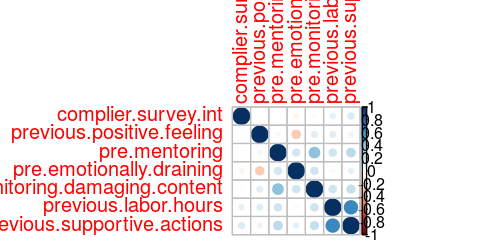

In [693]:
summary(participant$complier.survey.int)
#participant$previous.supportive.actions
#participant$diff.positive.feeling
#participant$previous.labor.hours
corrplot(cor(participant[c("complier.survey.int",
                           "previous.positive.feeling", 
                           "pre.mentoring",
                           "pre.emotionally.draining",
                           "pre.monitoring.damaging.content",
                           "previous.labor.hours",
                           "previous.supportive.actions")]))

In [698]:
summary(m1 <- glm(complier.survey.int ~ previous.supportive.actions, 
            data=participant, 
            family=binomial(link="logit")))

probobs <- m1$fitted


summary(probobs[participant$TREAT==0])
summary(probobs[participant$TREAT==1])
wt <- 1/probobs

summary(lm(diff.positive.feeling ~ TREAT, data=participant, subset=complier.survey.int==1))
summary(lm(diff.positive.feeling ~ TREAT, weights=wt, data=participant, subset=complier.survey.int==1))


Call:
glm(formula = complier.survey.int ~ previous.supportive.actions, 
    family = binomial(link = "logit"), data = participant)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4278  -0.8868  -0.8693   1.4414   1.5208  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -0.778540   0.120215  -6.476  9.4e-11 ***
previous.supportive.actions  0.004805   0.001734   2.771  0.00559 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 517.96  on 399  degrees of freedom
Residual deviance: 509.28  on 398  degrees of freedom
AIC: 513.28

Number of Fisher Scoring iterations: 4


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3146  0.3146  0.3219  0.3518  0.3503  0.8866 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3146  0.3157  0.3209  0.3482  0.3443  0.8353 


Call:
lm(formula = diff.positive.feeling ~ TREAT, data = participant, 
    subset = complier.survey.int == 1)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.15873 -0.15873  0.09091  0.09091  2.09091 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.15873    0.08632   1.839   0.0681 .
TREAT       -0.24964    0.11639  -2.145   0.0337 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6851 on 138 degrees of freedom
Multiple R-squared:  0.03226,	Adjusted R-squared:  0.02525 
F-statistic:   4.6 on 1 and 138 DF,  p-value: 0.03372



Call:
lm(formula = diff.positive.feeling ~ TREAT, data = participant, 
    subset = complier.survey.int == 1, weights = wt)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-3.8154 -0.2609  0.1275  0.1473  3.6647 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.14721    0.08702   1.692   0.0930 .
TREAT       -0.22994    0.11769  -1.954   0.0528 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.172 on 138 degrees of freedom
Multiple R-squared:  0.02692,	Adjusted R-squared:  0.01986 
F-statistic: 3.817 on 1 and 138 DF,  p-value: 0.05275


### Newcomer Capability and Skipping

Warning message:
“Removed 20 rows containing missing values (geom_point).”

Warning message:
“Removed 20 rows containing missing values (geom_point).”

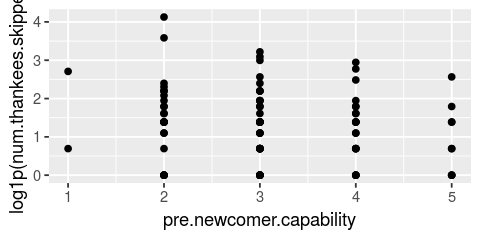

Warning message:
“Removed 20 rows containing missing values (geom_point).”

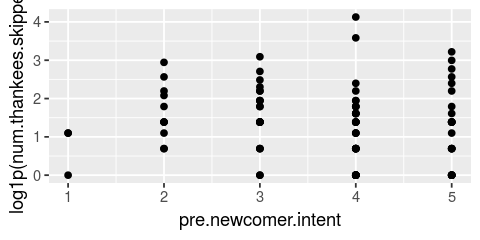

Warning message:
“Removed 20 rows containing missing values (geom_point).”

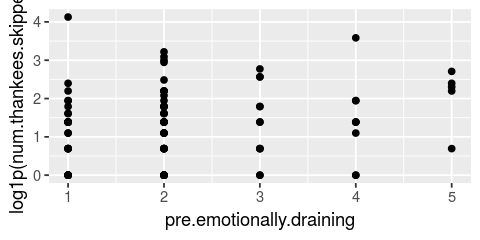

Warning message:
“Removed 20 rows containing missing values (geom_point).”

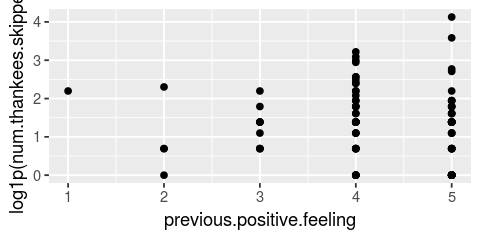

Warning message:
“Removed 20 rows containing missing values (geom_point).”

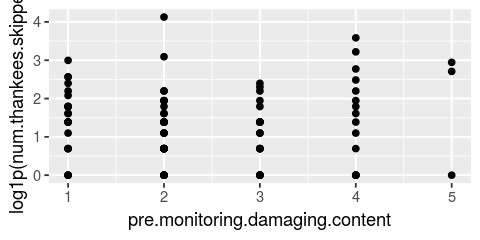

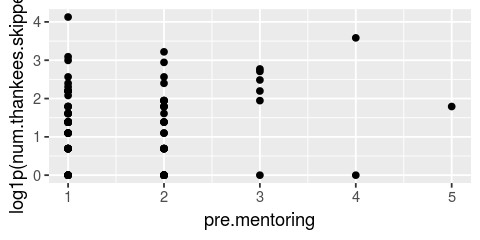

In [711]:
ggplot(subset(behavioral.compliers.login, TREAT==1), aes(pre.newcomer.capability, log1p(num.thankees.skipped))) +
    geom_point()

ggplot(subset(behavioral.compliers.login, TREAT==1), aes(pre.newcomer.intent, log1p(num.thankees.skipped))) +
    geom_point()

ggplot(subset(behavioral.compliers.login, TREAT==1), aes(pre.emotionally.draining, log1p(num.thankees.skipped))) +
    geom_point()

ggplot(subset(behavioral.compliers.login, TREAT==1), aes(previous.positive.feeling, log1p(num.thankees.skipped))) +
    geom_point()

ggplot(subset(behavioral.compliers.login, TREAT==1), aes(pre.monitoring.damaging.content, log1p(num.thankees.skipped))) +
    geom_point()

ggplot(subset(behavioral.compliers.login, TREAT==1), aes(pre.mentoring, log1p(num.thankees.skipped))) +
    geom_point()

Warning message:
“Removed 40 rows containing missing values (geom_point).”

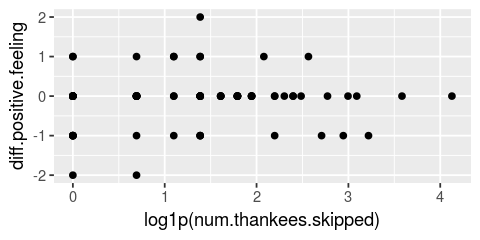

In [709]:
ggplot(subset(behavioral.compliers.login, TREAT==1), aes(log1p(num.thankees.skipped), diff.positive.feeling)) +
    geom_point()